Encontradas 86437 imagens
Dispositivo: cuda
Epoch 1/5
Train Loss: 1.2494 | Val Loss: 1.1523
Acc: 0.6607 | Prec: 0.3462 | Recall: 0.4148 | F1-macro: 0.3567
------------------------------------------------------------
Epoch 2/5
Train Loss: 1.0872 | Val Loss: 1.1112
Acc: 0.4420 | Prec: 0.3597 | Recall: 0.5033 | F1-macro: 0.3118
------------------------------------------------------------
Epoch 3/5
Train Loss: 0.9835 | Val Loss: 0.8977
Acc: 0.6070 | Prec: 0.4089 | Recall: 0.5922 | F1-macro: 0.4280
------------------------------------------------------------
Epoch 4/5
Train Loss: 0.8539 | Val Loss: 0.8337
Acc: 0.6606 | Prec: 0.4510 | Recall: 0.6470 | F1-macro: 0.4900
------------------------------------------------------------
Epoch 5/5
Train Loss: 0.7827 | Val Loss: 0.7469
Acc: 0.6380 | Prec: 0.4371 | Recall: 0.7252 | F1-macro: 0.4719
------------------------------------------------------------
Treinamento concluído!
Métricas salvas em: deit_tiny_metrics.csv
Matriz de Confusão:
 [[8552 296

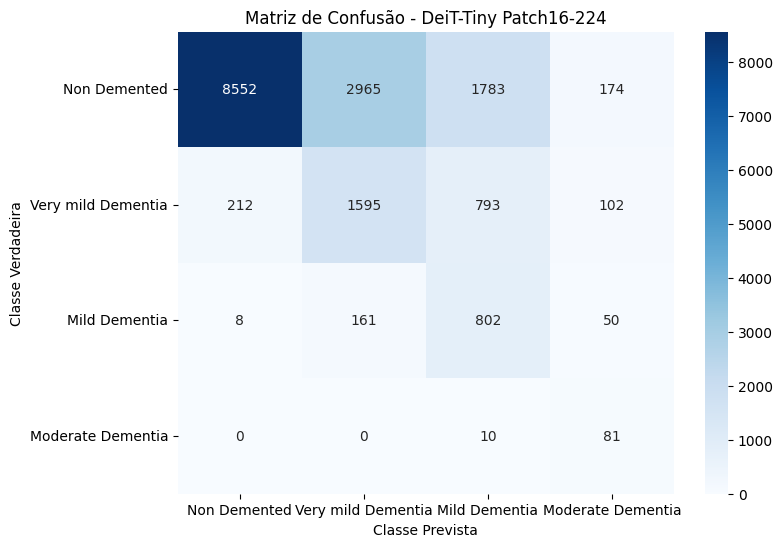

In [1]:
# ============================================================
# Imports
# ============================================================
import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
from PIL import Image
import polars as pl
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# NOVO import
import timm

# ============================================================
# Download do dataset OASIS via kagglehub
# ============================================================
# Link: https://www.kaggle.com/datasets/ninadaithal/imagesoasis
path = kagglehub.dataset_download("ninadaithal/imagesoasis")

data_path = Path(path) / "Data"

image_paths = []
for p in data_path.rglob('*.*'):
    if p.is_file():
        parts = p.parts
        if len(parts) >= 2:
            class_name = parts[-2]
            file_name = parts[-1]
            image_paths.append((class_name, file_name, str(p)))

print(f"Encontradas {len(image_paths)} imagens")

df = pl.DataFrame({
    'class': [x[0] for x in image_paths],
    'image': [x[1] for x in image_paths],
    'path': [x[2] for x in image_paths]
})

output_path = "oasis_dataset_metadata.parquet"
df.write_parquet(output_path)


# ============================================================
# Configurações básicas
# ============================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")

# Transformações (compatível com entrada 224x224)
transform = transforms.Compose([
    transforms.Resize((248, 496)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

class OASISDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.class_to_idx = {
            'Non Demented': 0,
            'Very mild Dementia': 1,
            'Mild Dementia': 2,
            'Moderate Dementia': 3
        }

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.row(idx)
        img_path = row[2]
        class_name = row[0]

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.class_to_idx[class_name]
        return image, label


df = pl.read_parquet("oasis_dataset_metadata.parquet")
dataset = OASISDataset(df, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


# ============================================================
# Modelo DeiT-Tiny (treino do zero) usando timm
# ============================================================
model = timm.create_model('deit_tiny_patch16_224', pretrained=False, num_classes=4)
model = model.to(device)

# Loss com pesos
class_weights = torch.tensor([0.3215, 1.5744, 4.3201, 44.2812], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


# ============================================================
# Treinamento
# ============================================================
num_epochs = 5
metrics_history = []

start_time = time.time()
for epoch in range(num_epochs):
    epoch_start = time.time()

    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    model.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    epoch_time = time.time() - epoch_start

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
    print(f'Acc: {acc:.4f} | Prec: {prec:.4f} | Recall: {rec:.4f} | F1-macro: {f1:.4f}')
    print('-' * 60)

    metrics_history.append({
        "epoch": epoch+1,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "accuracy": acc,
        "precision_macro": prec,
        "recall_macro": rec,
        "f1_macro": f1,
        "epoch_time_sec": epoch_time
    })

    scheduler.step()

print("Treinamento concluído!")

# ============================================================
# Salvar métricas
# ============================================================
metrics_df = pd.DataFrame(metrics_history)
metrics_df.to_csv("deit_tiny_metrics.csv", index=False)
print("Métricas salvas em: deit_tiny_metrics.csv")


# ============================================================
# Matriz de confusão
# ============================================================
cm = confusion_matrix(all_labels, all_preds)
print("Matriz de Confusão:\n", cm)

np.save("deit_tiny_confusion_matrix.npy", cm)

class_names = ['Non Demented', 'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão - DeiT-Tiny Patch16-224')
plt.show()